In [3]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load required functionality from keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16998723289697034760
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6661489754043158607
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

**Convolutional Neural Network (CNN)**
Now let's try out first deep neural network: a Convolutional Neural Network (CNN).

The CNN is made up of a few core layer types, which get stacked on top of each other:
- convolutional layers (2D)
- max pooling layers (2D)
- fully connected (aka densely connected) layers (same type as in the MLP model)


First, we need to perform pre-processing on the MNIST data, but with a slight tweak from the previous examples:

11493376/11490434 [==============================] - 4s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000, 784)


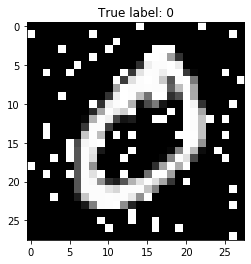

In [4]:
# load the data again (to be safe)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

"""
    Adding noise to image
"""
import random 

print(X_train.shape)
print(X_test.shape)

# 10%, 20%, 40%
img_size = 28*28

X_train_10 = np.zeros((60000, 28*28))
X_test_10 = np.zeros((10000, 28*28))
X_train_20 = np.zeros((60000, 28*28))
X_test_20 = np.zeros((10000, 28*28))
X_train_40 = np.zeros((60000, 28*28))
X_test_40 = np.zeros((10000, 28*28))

for i in range(len(X_train)): 
    ran_seq = random.sample([n for n in range(img_size)], np.int(img_size* 0.1)) 
    ran_seq2 = random.sample([n for n in range(img_size)], np.int(img_size* 0.2)) 
    ran_seq3 = random.sample([n for n in range(img_size)], np.int(img_size* 0.4)) 
    X_train_10[i] = X_train[i].reshape(-1, img_size) 
    X_train_20[i] = np.copy(X_train_10[i])
    X_train_40[i] = np.copy(X_train_10[i])
    X_train_10[i, ran_seq] = 255
    X_train_20[i, ran_seq2] = 255
    X_train_40[i, ran_seq3] = 255

for i in range(len(X_test)):
    ran_seq = random.sample([n for n in range(img_size)], np.int(img_size* 0.1)) 
    ran_seq2 = random.sample([n for n in range(img_size)], np.int(img_size* 0.2)) 
    ran_seq3 = random.sample([n for n in range(img_size)], np.int(img_size* 0.4)) 
    X_test_10[i] = X_test[i].reshape(-1, img_size) 
    X_test_20[i] = np.copy(X_test_10[i])
    X_test_40[i] = np.copy(X_test_10[i])
    X_test_10[i, ran_seq] = 255
    X_test_20[i, ran_seq2] = 255
    X_test_40[i, ran_seq3] = 255
    
print(X_train_10.shape)
#print(x[1])

img = X_train_10[1].reshape(28, 28)
label = y_train[1]

# show the image and its label
plt.imshow(img, cmap='gray')
plt.title("True label: %d" % label)
plt.show()



(60000, 28, 28, 1)


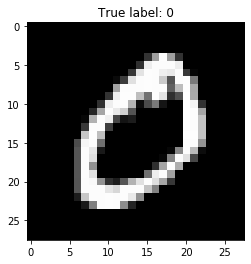

In [5]:
# reshape the data based on what backend is in use (TensorFlow or Thean)
if keras_backend.image_data_format() == 'channels_first': #Thean
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
else: # TensorFlow
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    X_train_10 = X_train_10.reshape(-1, 28, 28, 1)
    X_train_20 = X_train_20.reshape(-1, 28, 28, 1)
    X_train_40 = X_train_40.reshape(-1, 28, 28, 1)
    X_test_10 = X_test_10.reshape(-1, 28, 28, 1)
    X_test_20 = X_test_20.reshape(-1, 28, 28, 1)
    X_test_40 = X_test_40.reshape(-1, 28, 28, 1)

print(X_train.shape)

img = X_train[1, :, :, 0]
label = y_train[1]

# show the image and its label
plt.imshow(img, cmap='gray')
plt.title("True label: %d" % label)
plt.show()


# convert data type and normalize the values (8-bit = 256 = 0...255)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train_10 = X_train_10.astype('float32') / 255
X_train_20 = X_train_20.astype('float32') / 255
X_train_40 = X_train_40.astype('float32') / 255
X_test_10 = X_test_10.astype('float32') / 255
X_test_20 = X_test_20.astype('float32') / 255
X_test_40 = X_test_40.astype('float32') / 255

# convert the class labels to 10-dimensional class arrays:
# - before: y_train = (n_samples, )
# - after: Y_train = (n_samples, 10)
#
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [6]:
# create the CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1),
                 padding="same"
                ))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

print(model.summary())

model.compile(loss='mean_absolute_error',
              optimizer=Adam(),
              metrics=['accuracy'])

model.fit(X_train_40, X_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_40, X_test))

"""
print("== 10% ==")
model.fit(X_train_10, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_10, Y_test))

score = model.evaluate(X_test_10, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


print("== 20% ==")
model.fit(X_train_20, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_20, Y_test))

score = model.evaluate(X_test_20, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


print("== 40% ==")
model.fit(X_train_40, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_40, Y_test))

score = model.evaluate(X_test_40, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
"""

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)  

'\nprint("== 10% ==")\nmodel.fit(X_train_10, Y_train,\n          batch_size=128,\n          epochs=2,\n          verbose=1,\n          validation_data=(X_test_10, Y_test))\n\nscore = model.evaluate(X_test_10, Y_test, verbose=0)\n\nprint(\'Test loss:\', score[0])\nprint(\'Test accuracy:\', score[1])\n\n\nprint("== 20% ==")\nmodel.fit(X_train_20, Y_train,\n          batch_size=128,\n          epochs=2,\n          verbose=1,\n          validation_data=(X_test_20, Y_test))\n\nscore = model.evaluate(X_test_20, Y_test, verbose=0)\n\nprint(\'Test loss:\', score[0])\nprint(\'Test accuracy:\', score[1])\n\n\nprint("== 40% ==")\nmodel.fit(X_train_40, Y_train,\n          batch_size=128,\n          epochs=2,\n          verbose=1,\n          validation_data=(X_test_40, Y_test))\n\nscore = model.evaluate(X_test_40, Y_test, verbose=0)\n\nprint(\'Test loss:\', score[0])\nprint(\'Test accuracy:\', score[1])\n'

== Noise remove accuracy ==
Train loss: 0.019753999929626783
Train accuracy: 0.8143207702318828
Test loss: 0.01973995618224144
Test accuracy: 0.8133596942901611


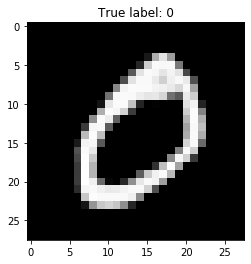

In [7]:
print("== Noise remove accuracy ==")
score = model.evaluate(X_train_40, X_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(X_test_40, X_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

X_train_10_removeNoise = model.predict(X_train_10)
X_train_20_removeNoise = model.predict(X_train_20)
X_train_40_removeNoise = model.predict(X_train_40)
X_test_10_removeNoise = model.predict(X_test_10)
X_test_20_removeNoise = model.predict(X_test_20)
X_test_40_removeNoise = model.predict(X_test_40)


img = X_train_40_removeNoise[1, :, :, 0]
label = y_train[1]

# show the image and its label
plt.imshow(img, cmap='gray')
plt.title("True label: %d" % label)
plt.show()

In [8]:
# create the CNN model
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)
                ))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

print("== 10% with remove noise ==")
model2.fit(X_train_10_removeNoise, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_10_removeNoise, Y_test))

score = model2.evaluate(X_test_10_removeNoise, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


print("== 20% with remove noise ==")
model2.fit(X_train_20_removeNoise, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_20_removeNoise, Y_test))

score = model2.evaluate(X_test_20_removeNoise, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


print("== 40% with remove noise ==")
model2.fit(X_train_40_removeNoise, Y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test_40_removeNoise, Y_test))

score = model2.evaluate(X_test_40_removeNoise, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

== 10% with remove noise ==
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 123us/step - loss: 0.3321 - acc: 0.8981 - val_loss: 0.0916 - val_acc: 0.9708
Epoch 2/2
60000/60000 [==============================] - 6s 104us/step - loss: 0.1334 - acc: 0.9591 - val_loss: 0.0724 - val_acc: 0.9767
Test loss: 0.07240031437918078
Test accuracy: 0.9767
== 20% with remove noise ==
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 106us/step - loss: 0.0751 - acc: 0.9773 - val_loss: 0.0419 - val_acc: 0.9868
Epoch 2/2
60000/60000 [==============================] - 6s 106us/step - loss: 0.0635 - acc: 0.9809 - val_loss: 0.0385 - val_acc: 0.9867
Test loss: 0.03852416750941775
Test accuracy: 0.9867
== 40% with remove noise ==
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 104us/step - loss: 0.0624 - acc: 0.9818 - val_loss: 